In [1]:
# 共通事前処理

# 余計なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from monthdelta import monthmod

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# Numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.1f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)
# 乱数の種
random_seed = 123

In [2]:
# データフレーム化
df1 = pd.read_csv('https://raw.githubusercontent.com/Oshiruko-TsubuAn/sample_usedcar_data/main/F31_320dMsp(UTF-8).csv', index_col=0)

# 確認
display(df1.head())

,year_,odo,price,ins,color
0,2017,34000,3180000,車検整備付,黒Ｍ
1,2016,35000,2880000,車検整備付,黒
2,2016,31000,3180000,2021-11-01,黒
3,2015,57000,2280000,2022-03-01,黒Ｍ
4,2015,52000,2398000,2022-03-01,白


In [3]:
# データ前処理1
df2 = df1.copy()

# 車検なしのものを当月に置換
today = datetime.today()
this_month = today.strftime('%Y-%m-01')
df2 = df2.replace({'ins': {'車検整備付': this_month, '車検整備無': this_month, '車検整備別': this_month}})

# 車検までの残月数
thism_type_d = datetime.strptime(this_month, '%Y-%m-%d')
df2['ins'] = pd.to_datetime(df2['ins'])
df2['this_month'] = thism_type_d
df2['ins_left_days'] = (df2['ins'] - df2['this_month']).dt.days
df2.ins_left_days[df2.ins_left_days < 0] = 0     # マイナスのものを0に置換
df2['ins_left'] = df2['ins_left_days'] / 30.4375

# 色の表記ゆれを修正
df2['color'] = df2['color'].str.replace('M', '')
df2['color'] = df2['color'].str.replace('Ｍ', '')
df2['color'] = df2['color'].str.replace('真珠', '白')
df2['color'] = df2['color'].str.replace('薄', '')
df2['color'] = df2['color'].str.replace('I', '')
df2['color'] = df2['color'].str.replace('深', '')
df2 = df2.replace({'color': {'(.)(.*)': r'\1'}}, regex=True)

# 確認
display(df2.head())

,year_,odo,price,ins,color,this_month,ins_left_days,ins_left
0,2017,34000,3180000,2021-05-01,黒,2021-05-01,0,0.0
1,2016,35000,2880000,2021-05-01,黒,2021-05-01,0,0.0
2,2016,31000,3180000,2021-11-01,黒,2021-05-01,184,6.0
3,2015,57000,2280000,2022-03-01,黒,2021-05-01,304,10.0
4,2015,52000,2398000,2022-03-01,白,2021-05-01,304,10.0


行数, 列数: (125, 8)

色別の台数
白    79
黒    31
青     9
銀     3
赤     3
Name: color, dtype: int64


,year_,odo,price,ins_left_days,ins_left
count,125.0,125.0,125.0,125.0,125.0
mean,2015.1,48800.0,2415848.0,175.2,5.8
std,1.6,31463.0,642368.6,191.1,6.3
min,2012.0,2000.0,792000.0,0.0,0.0
25%,2014.0,29000.0,1888000.0,0.0,0.0
50%,2015.0,41000.0,2498000.0,123.0,4.0
75%,2016.0,61000.0,2930000.0,335.0,11.0
max,2018.0,182000.0,3880000.0,641.0,21.1


array([[<AxesSubplot:title={'center':'year_'}>,
        <AxesSubplot:title={'center':'odo'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'ins_left_days'}>],
       [<AxesSubplot:title={'center':'ins_left'}>, <AxesSubplot:>]],
      dtype=object)

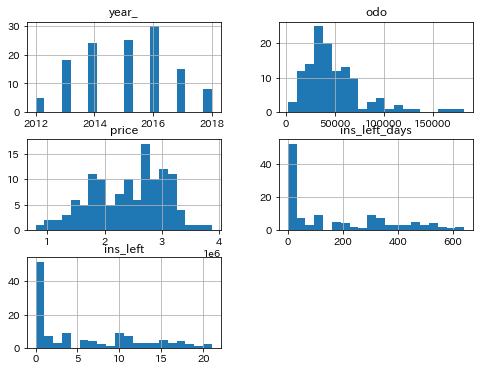

In [4]:
print('行数, 列数:', df2.shape)
print('\n色別の台数')
print(df2['color'].value_counts())
display(df2.describe())
df2.hist(figsize=(8,6), bins=20)

In [5]:
# データ前処理2 (One-Hotエンコーディング)

# One-Hotエンコーディング用の関数
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column], axis=1), df_dummy], axis=1)
    return df

# colorをOne-Hotエンコーディング
df3 = enc(df2, 'color')

# 不要列をドロップ
df3 = df3.drop(['ins'], axis=1)
df3 = df3.drop(['ins_left_days'], axis=1)
df3 = df3.drop(['this_month'], axis=1)

# 確認
display(df3.head())

,year_,odo,price,ins_left,color_白,color_赤,color_銀,color_青,color_黒
0,2017,34000,3180000,0.0,0,0,0,0,1
1,2016,35000,2880000,0.0,0,0,0,0,1
2,2016,31000,3180000,6.0,0,0,0,0,1
3,2015,57000,2280000,10.0,0,0,0,0,1
4,2015,52000,2398000,10.0,1,0,0,0,0


In [6]:
# 入力データと正解データの分割
x = df3.drop('price', axis=1)
y = df3['price'].values

# 正解データと検証データの分割
test_size = 0.2

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_seed)

In [7]:
# アルゴリズムの選択
from sklearn.metrics import r2_score

# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
algorithm_LR = LogisticRegression(random_state=random_seed)
algorithm_LR.fit(x_train, y_train)
ypred_LR = algorithm_LR.predict(x_test)
score_LR = r2_score(y_test, ypred_LR)
print(f'score LogisticRegression: {score_LR}')

# XGBRegressor
from xgboost import XGBRegressor
algorithm_XGBR = XGBRegressor(random_state=random_seed)
algorithm_XGBR.fit(x_train, y_train)
ypred_XGBR = algorithm_XGBR.predict(x_test)
score_XGBR = r2_score(y_test, ypred_XGBR)
print(f'score XGBRegressor: {score_XGBR}')

score LogisticRegression: 0.492272185504524
score XGBRegressor: 0.6692589579514605


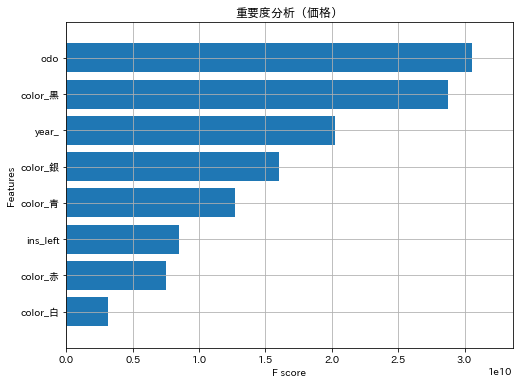

In [8]:
# 重要度分析
import xgboost as xgb
fig, ax = plt.subplots(figsize=(8,6))
xgb.plot_importance(algorithm_XGBR, ax=ax, height=0.8, importance_type='gain', show_values=False, title='重要度分析（価格）')
plt.show()

In [9]:
# 価格予測用の辞書の元
k = df3.columns.values
v = [0 for i in range(len(k))]
dic_sample = {k: v for k, v in zip(k, v)}
print(dic_sample)

{'year_': 0, 'odo': 0, 'price': 0, 'ins_left': 0, 'color_白': 0, 'color_赤': 0, 'color_銀': 0, 'color_青': 0, 'color_黒': 0}


In [10]:
# 価格予測
dic = {'year_': 2018, 'odo': 10000, 'ins_left': 0, 'color_白': 1, 'color_赤': 0, 'color_銀': 0, 'color_青': 0, 'color_黒': 0}
df_pred = pd.DataFrame([dic])

XGB_pred = algorithm_XGBR.predict(df_pred)
print(f'price: {XGB_pred}')

price: [3142447.]
